<a href="https://colab.research.google.com/github/martinfernandoortiz/geoestadistica_unlp/blob/main/segundo_trabajo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
# *Manejo de muestras de datos*
## Repaso de conceptos – Práctica 2
## Geoestadı́stica -Maestrı́a en Geomática UNLP

En un estudio global en todo el paı́s se registraron una serie de mediciones meteorológicas mensuales durante el perı́odo 1981-2010. Con el fin de caracterizar tendencias climatológicas se generó un base de datos.
En principio, como primera medida, se necesita identificar las principales
caracterı́sticas estadı́sticas de este set de datos con el fin de tener un re-
sultado rápido pero consistente. De esta manera se decidió que lo más
conveniente serı́a identificar en una tabla, por variable meteorológica, lo
siguiente:
    
***

## Carga de librerías y dataset

In [2]:
################################################################
#
#   - Importacion de librerias
#   - Asignaciòn de alias
#
####################################################################

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
#import geopandas as gpd
# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
#https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0

#Import Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Carga de datos

#path = "datasets/"
archivo = "SMN_estaciones_medias_mensuales_1989_2010.xls"
#df = pd.read_excel( 'SMN_estaciones_medias_mensuales_1989_2010.xls')
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/SMN_estaciones_medias_mensuales_1989_2010.xls')
df.replace("S/D", np.NaN, inplace = True) #reemplazar los "S/D"

#df['Temperatura_minima_(C)'].mean()

In [12]:
#Finalmente vamos a utilizar ésta forma para cambiar el tipo de campo
rango= np.r_[8:16]
df[df.columns[rango]] = df[df.columns[rango]].astype(float)
df.dtypes
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0.1                           840 non-null    int64  
 1   Unnamed: 0                             840 non-null    int64  
 2   Estacion                               840 non-null    object 
 3   mes                                    840 non-null    object 
 4   lat                                    840 non-null    float64
 5   long                                   840 non-null    float64
 6   Altura_(m)                             840 non-null    int64  
 7   Numero                                 840 non-null    int64  
 8   Temperatura_(C)                        838 non-null    float64
 9   Temperatura_maxima_(C)                 840 non-null    float64
 10  Temperatura_minima_(C)                 818 non-null    float64
 11  Humeda

In [6]:
# Ver si reemplazamos outliers por na o por otra medida
def f(row):
    if (row[colname] < lower_lim) | (row[colname] > upper_lim):
        val = np.NaN
    else:
        val = row[colname]

    return val


In [13]:
def replace_outliers_with_limits(df, column_range, multiplier=1.5):
    for column_name in df.columns[column_range]:
        # Calcular la media y la desviación estándar de la columna
        mean_value = df[column_name].mean()
        std_value = df[column_name].std()

        # Calcular los límites del bigote (whisker)
        lower_limit = mean_value - multiplier * std_value
        upper_limit = mean_value + multiplier * std_value

        # Reemplazar los valores NaN por la media de la columna
        df[column_name].fillna(mean_value, inplace=True)

        # Identificar y reemplazar los outliers inferiores
        lower_outliers = df[column_name] < lower_limit
        df.loc[lower_outliers, column_name] = lower_limit

        # Identificar y reemplazar los outliers superiores
        upper_outliers = df[column_name] > upper_limit
        df.loc[upper_outliers, column_name] = upper_limit

    return df


# df = replace_outliers_with_limits(df, np.r_[8:15])

In [23]:
# Reemplazo los outliers
rango= np.r_[8:16]

df1 = df[df.columns[rango]]
df1  = replace_outliers_with_limits(df1, np.r_[0:7])
#df1[df1.columns[ np.r_[8:16]]] = df[df.columns[rango]]

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Temperatura_(C)                        840 non-null    float64
 1   Temperatura_maxima_(C)                 840 non-null    float64
 2   Temperatura_minima_(C)                 840 non-null    float64
 3   Humedad_relativa_(%)                   840 non-null    float64
 4   Velocidad_del_Viento_(km/h)            840 non-null    float64
 5   Nubosidad_total_(octavos)              840 non-null    float64
 6   Precipitacion_(mm)                     840 non-null    float64
 7   Frecuencia_dias_Precipitacion_>0.1_mm  840 non-null    float64
dtypes: float64(8)
memory usage: 52.6 KB


In [24]:
df1.head()

,Temperatura_(C),Temperatura_maxima_(C),Temperatura_minima_(C),Humedad_relativa_(%),Velocidad_del_Viento_(km/h),Nubosidad_total_(octavos),Precipitacion_(mm),Frecuencia_dias_Precipitacion_>0.1_mm
0,12.800000,20.1,7.40000,65.30000,6.9,4.618394,97.5,10.901680
1,12.500000,19.9,7.00000,64.10000,7.1,4.618394,68.4,10.901680
2,12.400000,19.9,6.30000,62.40000,6.5,4.100000,55.9,9.800000
3,10.900000,19.7,2.80000,54.58063,6.4,2.916007,8.2,2.612075
4,6.976699,17.3,1.48679,54.58063,6.0,2.916007,1.0,2.612075


In [ ]:
# df1=df1.iloc[:, np.r_[8:16]]

In [25]:
df1['Temperatura_minima_(C)'].mean()

10.54419023082251

In [26]:
#Media

print('----------------------')
print('Media de cada variable')
print('----------------------')
df.mean(axis=0, numeric_only = True)



----------------------
Media de cada variable
----------------------


Unnamed: 0.1                               419.500000
Unnamed: 0                                 425.112948
lat                                        -31.455232
long                                       -57.741740
Altura_(m)                                 339.842857
Numero                                   87500.842857
Temperatura_(C)                             16.206180
Temperatura_maxima_(C)                      22.862769
Temperatura_minima_(C)                      10.481767
Humedad_relativa_(%)                        68.596860
Velocidad_del_Viento_(km/h)                 12.136814
Nubosidad_total_(octavos)                    3.767201
Precipitacion_(mm)                          67.196950
Frecuencia_dias_Precipitacion_>0.1_mm        6.741693
dtype: float64

In [27]:
print('-------------------------')
print('Varianza de cada variable')
print('-------------------------')
df.var(axis=0) # Entrenamiento modelo PCA con escalado de los datos


-------------------------
Varianza de cada variable
-------------------------


Unnamed: 0.1                              56004.221692
Unnamed: 0                                58685.529362
lat                                          71.048752
long                                        123.912890
Altura_(m)                               241663.169556
Numero                                   127838.120688
Temperatura_(C)                              37.859250
Temperatura_maxima_(C)                       39.530233
Temperatura_minima_(C)                       35.959827
Humedad_relativa_(%)                         87.313210
Velocidad_del_Viento_(km/h)                  17.178439
Nubosidad_total_(octavos)                     0.322014
Precipitacion_(mm)                         2178.925405
Frecuencia_dias_Precipitacion_>0.1_mm         5.705100
dtype: float64

In [28]:
df['Estacion']

0            LA QUIACA
1            LA QUIACA
2            LA QUIACA
3            LA QUIACA
4            LA QUIACA
            ...       
835    BASE SAN MARTIN
836    BASE SAN MARTIN
837    BASE SAN MARTIN
838    BASE SAN MARTIN
839    BASE SAN MARTIN
Name: Estacion, Length: 840, dtype: object

In [29]:
X_std = StandardScaler().fit_transform(X)

NameError: ignored

In [ ]:
X_std

array([[-0.55391134, -0.43968193, -0.51422081, ...,  2.11114616,
         0.6495668 ,  1.7426855 ],
       [-0.60269719, -0.471511  , -0.58096444, ...,  1.82111534,
         0.0257882 ,  1.7426855 ],
       [-0.61895914, -0.471511  , -0.6977658 , ...,  0.58681864,
        -0.24215794,  1.28117396],
       ...,
       [-1.76103752, -1.84872971, -1.73864483, ...,  2.11114616,
         0.04582937,  0.00636088],
       [-1.76103752, -1.84872971, -1.73864483, ...,  2.11114616,
         0.04582937,  0.00636088],
       [-1.76103752, -1.84872971, -1.73864483, ...,  2.11114616,
         0.04582937,  0.00636088]])

In [ ]:
# Calculamos la matriz de covarianza

print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))



NumPy covariance matrix: 
[[ 1.0011919   0.98503739  0.97438591 -0.12541886 -0.22033743 -0.41075686
   0.61183998  0.3892094 ]
 [ 0.98503739  1.0011919   0.94006507 -0.21452446 -0.26537916 -0.47932947
   0.53851248  0.30701386]
 [ 0.97438591  0.94006507  1.0011919   0.00324575 -0.23583834 -0.33758658
   0.66175472  0.44125108]
 [-0.12541886 -0.21452446  0.00324575  1.0011919  -0.20437937  0.41376008
   0.37156794  0.3681683 ]
 [-0.22033743 -0.26537916 -0.23583834 -0.20437937  1.0011919   0.23929917
  -0.07531678  0.10261437]
 [-0.41075686 -0.47932947 -0.33758658  0.41376008  0.23929917  1.0011919
   0.02216611  0.337404  ]
 [ 0.61183998  0.53851248  0.66175472  0.37156794 -0.07531678  0.02216611
   1.0011919   0.82594063]
 [ 0.3892094   0.30701386  0.44125108  0.3681683   0.10261437  0.337404
   0.82594063  1.0011919 ]]


In [ ]:
#Calculamos los autovalores y autovectores de la matriz y los mostramos
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.49108273  0.1230824   0.06917832 -0.14030651 -0.23477484  0.79333162
  -0.18087785  0.04478656]
 [ 0.47764283  0.19693991  0.0498487  -0.175243   -0.15273808 -0.54910145
  -0.60946189  0.05993225]
 [ 0.49204956  0.04767119  0.01642562 -0.10945551 -0.32899558 -0.25989621
   0.75295064  0.02540826]
 [ 0.01460079 -0.51808246 -0.48488755  0.40563471 -0.52932187 -0.01495687
  -0.14938803  0.17029328]
 [-0.13913609 -0.12349036  0.84010912  0.33254313 -0.38133434 -0.03356975
  -0.04960118  0.00446405]
 [-0.18162855 -0.52946174  0.09302664 -0.75836869 -0.21423966 -0.00902838
  -0.04890398 -0.2335221 ]
 [ 0.3946485  -0.35976757  0.04486655  0.2945118   0.32467318 -0.01053381
  -0.03073723 -0.72083371]
 [ 0.2833265  -0.50037097  0.20222125 -0.02527358  0.48621492 -0.00483652
   0.02813     0.62498253]]

Eigenvalues 
[3.86243711 2.09997571 1.12782859 0.44210338 0.33981071 0.00605814
 0.03249033 0.0988312 ]


In [ ]:

#  Hacemos una lista de parejas (autovector, autovalor)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Ordenamos estas parejas den orden descendiente con la función sort
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visualizamos la lista de autovalores en orden desdenciente
print('Autovalores en orden descendiente:')
for i in eig_pairs:
    print(i[0])

Autovalores en orden descendiente:
3.8624371098689405
2.0999757051818433
1.1278285883002441
0.44210337529534943
0.33981070801314034
0.09883120257448375
0.03249032835729555
0.006058143314547163


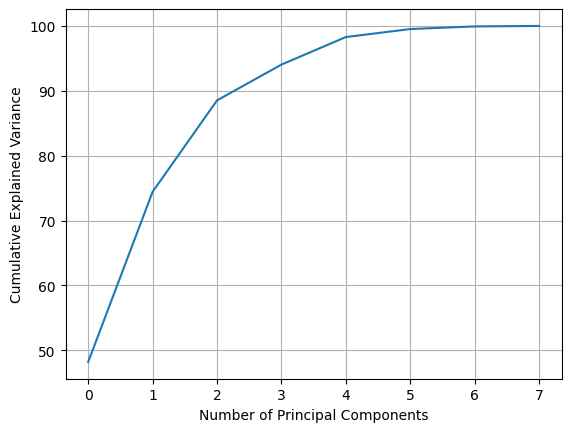

In [ ]:
# A partir de los autovalores, calculamos la varianza explicada
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.plot(np.cumsum(var_exp))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

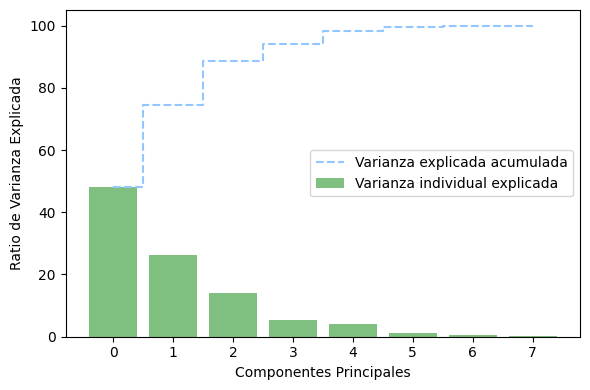

In [ ]:
# Representamos en un diagrama de barras la varianza explicada por cada autovalor, y la acumulada
with plt.style.context('seaborn-pastel'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(8), var_exp, alpha=0.5, align='center',
            label='Varianza individual explicada', color='g')
    plt.step(range(8), cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
    plt.ylabel('Ratio de Varianza Explicada')
    plt.xlabel('Componentes Principales')
    plt.legend(loc='best')
    plt.tight_layout()

In [ ]:
#Generamos la matríz a partir de los pares autovalor-autovector
matrix_w = np.hstack((eig_pairs[0][1].reshape(8,1),
                      eig_pairs[1][1].reshape(8,1)))
print('Matriz W:\n', matrix_w)
Y = X_std.dot(matrix_w)

Matriz W:
 [[ 0.49108273  0.1230824 ]
 [ 0.47764283  0.19693991]
 [ 0.49204956  0.04767119]
 [ 0.01460079 -0.51808246]
 [-0.13913609 -0.12349036]
 [-0.18162855 -0.52946174]
 [ 0.3946485  -0.35976757]
 [ 0.2833265  -0.50037097]]


In [ ]:
Y

array([[-0.19764561, -2.06370967],
       [-0.47173714, -1.64057839],
       [-0.53201873, -0.55511037],
       ...,
       [-3.24196549, -2.01389319],
       [-3.20501678, -1.98109932],
       [-3.17478602, -1.95426798]])

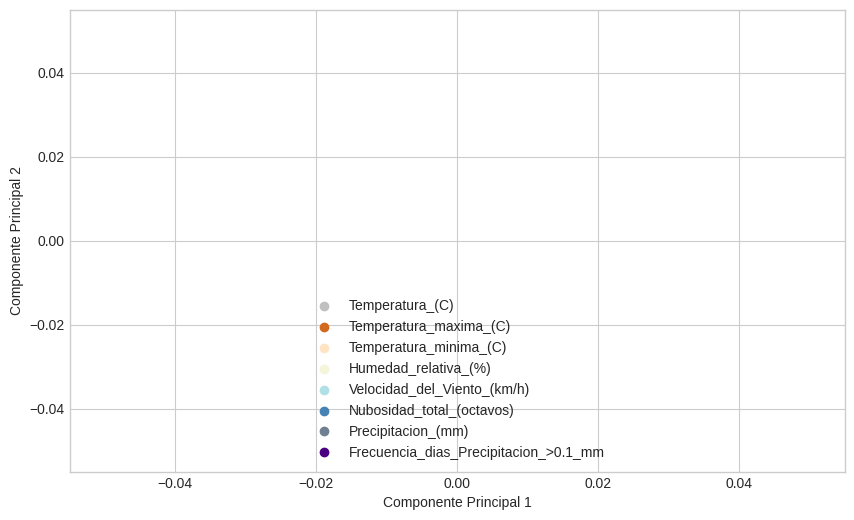

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 6))
    for lab, col in zip(('Temperatura_(C)', 'Temperatura_maxima_(C)', 'Temperatura_minima_(C)',
       'Humedad_relativa_(%)', 'Velocidad_del_Viento_(km/h)',
       'Nubosidad_total_(octavos)', 'Precipitacion_(mm)',
       'Frecuencia_dias_Precipitacion_>0.1_mm'),
                        ('silver', 'chocolate', 'bisque','beige', 'powderblue', 'steelblue','slategray', 'indigo')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend(loc='lower center')
    #plt.tight_layout()
    plt.show()

In [ ]:
df1.tail()

,Temperatura_(C),Temperatura_maxima_(C),Temperatura_minima_(C),Humedad_relativa_(%),Velocidad_del_Viento_(km/h),Nubosidad_total_(octavos),Precipitacion_(mm),Frecuencia_dias_Precipitacion_>0.1_mm
835,5.376991,11.246158,0.061928,68.044581,18.9,4.964484,69.334944,6.756877
836,5.376991,11.246158,0.061928,68.044581,17.5,4.964484,69.334944,6.756877
837,5.376991,11.246158,0.061928,68.044581,20.3,4.964484,69.334944,6.756877
838,5.376991,11.246158,0.061928,68.044581,19.2,4.964484,69.334944,6.756877
839,5.376991,11.246158,0.061928,68.044581,18.3,4.964484,69.334944,6.756877


In [ ]:

# Step 1: Extract numeric columns
numeric_columns = df1.select_dtypes(include=[np.number])

# Step 2: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_columns)

# Step 3: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Step 4: Creating a DataFrame with Principal Components
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Concatenate with the original DataFrame if needed
final_df = pd.concat([df, pca_df], axis=1)

# Step 5: Scatter plot of the first two principal components using seaborn
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 6))

categories = ['Temperatura_(C)', 'Temperatura_maxima_(C)', 'Temperatura_minima_(C)',
              'Humedad_relativa_(%)', 'Velocidad_del_Viento_(km/h)',
              'Nubosidad_total_(octavos)', 'Precipitacion_(mm)',
              'Frecuencia_dias_Precipitacion_>0.1_mm']

colors = ['silver', 'chocolate', 'bisque', 'beige', 'powderblue', 'steelblue', 'slategray', 'indigo']

# Create a DataFrame for plotting
plot_data = pd.DataFrame(data={'PC1': final_df['PC1'], 'PC2': final_df['PC2'], 'variable': final_df['variable']})

# Use seaborn to create a scatter plot with hue (color) based on 'variable'
sns.scatterplot(data=plot_data, x='PC1', y='PC2', hue='variable', palette=colors, s=50)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower center')
plt.title('Scatter Plot of Principal Components 1 and 2')
plt.show()

KeyError: ignored

<Figure size 1000x600 with 0 Axes>

In [30]:
numeric_data = df1.select_dtypes(include=[np.number])
normalized_data = (numeric_data - numeric_data.mean()) / numeric_data.std()

pca = PCA()
pca_result = pca.fit_transform(normalized_data)

print("Standard deviation:")
print(np.sqrt(pca.explained_variance_))

print("\nProportion of variance:")
print(pca.explained_variance_ratio_)
print("\nCumulative proportion:")
print(np.cumsum(pca.explained_variance_ratio_))


print("\nEigenvalues:")
print(pca.explained_variance_)


# Imprimir los vectores de carga (Variable Loadings)
print("\nVariable Loadings:")
print(pd.DataFrame(pca.components_.T, index=numeric_data.columns, columns=[f"PC{i+1}" for i in range(pca.n_components_)]))

Standard deviation:
[1.97053338 1.43523502 1.05845618 0.67734103 0.5871572  0.30222846
 0.18823663 0.08030962]

Proportion of variance:
[0.48537523 0.25748744 0.14004119 0.05734886 0.0430942  0.01141776
 0.00442913 0.0008062 ]

Cumulative proportion:
[0.48537523 0.74286267 0.88290386 0.94025271 0.98334691 0.99476467
 0.9991938  1.        ]

Eigenvalues:
[3.88300181 2.05989955 1.12032949 0.45879087 0.34475357 0.09134204
 0.03543303 0.00644964]

Variable Loadings:
                                            PC1       PC2       PC3       PC4  \
Temperatura_(C)                        0.489744 -0.123564  0.051458  0.124477   
Temperatura_maxima_(C)                 0.476423 -0.195117  0.036932  0.166988   
Temperatura_minima_(C)                 0.489903 -0.049860 -0.002863  0.079979   
Humedad_relativa_(%)                   0.011931  0.527683 -0.463563 -0.472615   
Velocidad_del_Viento_(km/h)           -0.118795  0.119905  0.856245 -0.337414   
Nubosidad_total_(octavos)             -0.187367

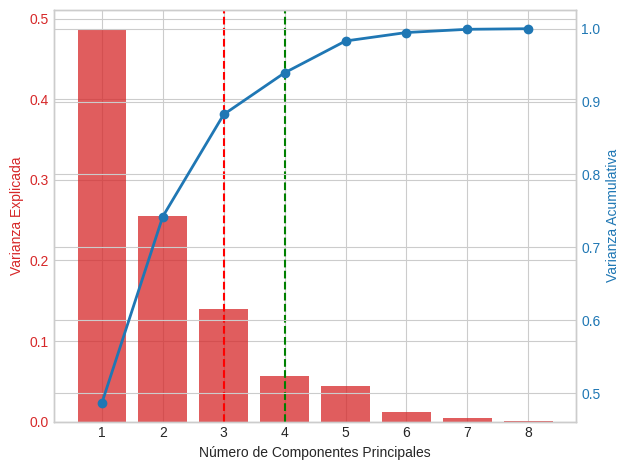

In [ ]:

# Obtener la varianza explicada y acumulativa
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Crear un DataFrame para facilitar la manipulación y ordenar por varianza explicada descendente
explained_variance_df = pd.DataFrame({'Componente': range(1, len(explained_variance) + 1),
                                      'Varianza Explicada': explained_variance,
                                      'Varianza Acumulativa': cumulative_explained_variance})
explained_variance_df = explained_variance_df.sort_values(by='Varianza Explicada', ascending=False)

# Crear el gráfico de barras y la línea de varianza acumulativa
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Número de Componentes Principales')
ax1.set_ylabel('Varianza Explicada', color=color)
ax1.bar(explained_variance_df['Componente'], explained_variance_df['Varianza Explicada'], color=color, alpha=0.75)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Varianza Acumul# Obtener la varianza explicada y acumulativa
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Crear un DataFrame para facilitar la manipulación y ordenar por varianza explicada descendente
explained_variance_df = pd.DataFrame({'Componente': range(1, len(explained_variance) + 1),
                                      'Varianza Explicada': explained_variance,
                                      'Varianza Acumulativa': cumulative_explained_variance})
explained_variance_df = explained_variance_df.sort_values(by='Varianza Explicada', ascending=False)

# Crear el gráfico de barras y la línea de varianza acumulativa
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Número de Componentes Principales')
ax1.set_ylabel('Varianza Explicada', color=color)
ax1.bar(explained_variance_df['Componente'], explained_variance_df['Varianza Explicada'], color=color, alpha=0.75)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Varianza Acumulativa', color=color)
ax2.plot(explained_variance_df['Componente'], explained_variance_df['Varianza Acumulativa'], color=color, marker='o', linestyle='-', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Añadir líneas para indicar el Kaiser criterion y el 95% threshold criterion
ax1.axvline(x=3, color='r', linestyle='--', label='Kaiser Criterion')
ax1.axvline(x=4, color='g', linestyle='--', label='95% Threshold Criterion')

# Ajustar el diseño del gráfico
fig.tight_layout()

# Mostrar el gráfico
plt.show()ativa', color=color)
ax2.plot(explained_variance_df['Componente'], explained_variance_df['Varianza Acumulativa'], color=color, marker='o', linestyle='-', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Añadir líneas para indicar el Kaiser criterion y el 95% threshold criterion
ax1.axvline(x=3, color='r', linestyle='--', label='Kaiser Criterion')
ax1.axvline(x=4, color='g', linestyle='--', label='95% Threshold Criterion')

# Ajustar el diseño del gráfico
fig.tight_layout()

# Mostrar el gráfico
plt.show()

In [ ]:
import plotly.graph_objects as go

# Obtener la varianza explicada y acumulativa
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Crear un DataFrame para facilitar la manipulación y ordenar por varianza explicada descendente
explained_variance_df = pd.DataFrame({'Componente': range(1, len(explained_variance) + 1),
                                      'Varianza Explicada': explained_variance,
                                      'Varianza Acumulativa': cumulative_explained_variance})
explained_variance_df = explained_variance_df.sort_values(by='Varianza Explicada', ascending=False)

# Crear subgráfico para Varianza Explicada
fig_bar = go.Figure()

fig_bar.add_trace(go.Bar(x=explained_variance_df['Componente'], y=explained_variance_df['Varianza Explicada'], name='Varianza Explicada', marker_color='skyblue'))
fig_bar.add_shape(go.layout.Shape(type='line', x0=3, x1=3, y0=0, y1=1, line=dict(color='red', dash='dash')))
fig_bar.add_shape(go.layout.Shape(type='line', x0=4, x1=4, y0=0, y1=1, line=dict(color='green', dash='dash')))

fig_bar.update_layout(xaxis_title='Número de Componentes Principales',
                      yaxis=dict(title='Varianza Explicada', color='skyblue'),
                      title='Varianza Explicada vs Número de Componentes Principales')
# Configurar el tema
fig_bar.update_layout(template="plotly_dark")
# Crear subgráfico para Varianza Acumulativa
fig_line = go.Figure()

fig_line.add_trace(go.Scatter(x=explained_variance_df['Componente'], y=explained_variance_df['Varianza Acumulativa'],
                              mode='lines+markers', name='Varianza Acumulativa', line=dict(color='orange', width=2)))
fig_line.add_shape(go.layout.Shape(type='line', x0=3, x1=3, y0=0, y1=1, line=dict(color='red', dash='dash')))
fig_line.add_shape(go.layout.Shape(type='line', x0=4, x1=4, y0=0, y1=1, line=dict(color='green', dash='dash')))

fig_line.update_layout(xaxis_title='Número de Componentes Principales',
                       yaxis=dict(title='Varianza Acumulativa', color='orange'),
                       title='Varianza Acumulativa vs Número de Componentes Principales')

# Configurar el tema
fig_line.update_layout(template="plotly_dark")
# Mostrar los gráficos interactivos
fig_bar.show()
fig_line.show()



Seleccionar dos variables originales que mejor se correlacionen con
las PC1, 2 y 3 (con cada PC por separado). Indicar el valor del
coeficiente de correlación r2 . Graficar en diferentes scatterplot las
relaciones entre estas variables.


Variables seleccionadas para PC1:
                  Variable       PC1
2  Temperatura_minima_(C)  0.489014
0         Temperatura_(C)  0.488962

Variables seleccionadas para PC2:
                     Variable       PC2
3       Humedad_relativa_(%)  0.531442
5  Nubosidad_total_(octavos)  0.529235

Variables seleccionadas para PC3:
                                 Variable       PC3
4            Velocidad_del_Viento_(km/h)  0.857298
7  Frecuencia_dias_Precipitacion_>0.1_mm  0.202098


<Figure size 1500x1500 with 0 Axes>

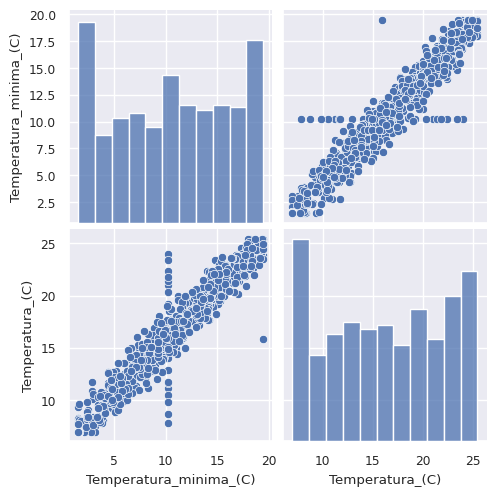

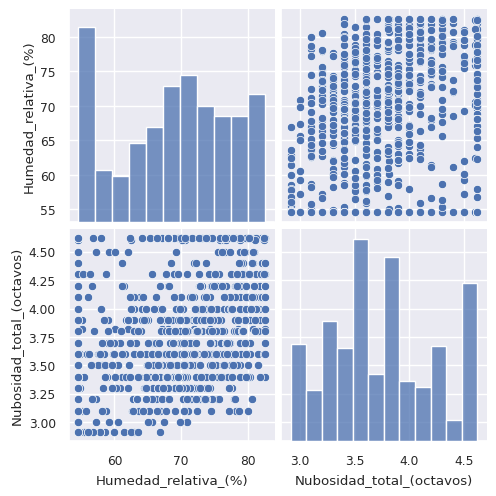

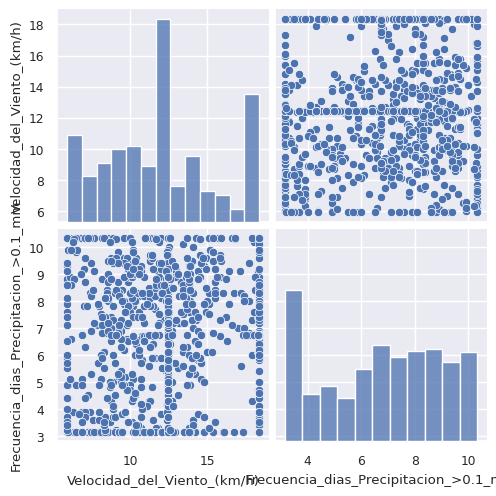

In [ ]:

# Configurar la opción para que las columnas no se truncen
pd.set_option('display.max_colwidth', None)

# Resto del código...

# Obtener los vectores de carga para PC1, PC2 y PC3
loadings_pc1 = pca.components_[0]
loadings_pc2 = pca.components_[1]
loadings_pc3 = pca.components_[2]

# Crear un DataFrame con los loadings y los nombres de las variables originales
loadings_df = pd.DataFrame({'Variable': numeric_data.columns, 'PC1': loadings_pc1, 'PC2': loadings_pc2, 'PC3': loadings_pc3})

# Seleccionar las dos variables con los mayores loadings absolutos para PC1, PC2 y PC3
selected_variables_pc1 = loadings_df[['Variable', 'PC1']].nlargest(2, 'PC1')
selected_variables_pc2 = loadings_df[['Variable', 'PC2']].nlargest(2, 'PC2')
selected_variables_pc3 = loadings_df[['Variable', 'PC3']].nlargest(2, 'PC3')

# Imprimir las variables seleccionadas para cada PC
print("Variables seleccionadas para PC1:\n", selected_variables_pc1)
print("\nVariables seleccionadas para PC2:\n", selected_variables_pc2)
print("\nVariables seleccionadas para PC3:\n", selected_variables_pc3)


sns.set(font_scale=0.8)  # Puedes ajustar el valor según tus preferencias
# Configurar el tamaño de las figuras para los scatterplots
plt.figure(figsize=(15, 15))  # Puedes ajustar los valores de ancho y alto según tus necesidades

# Graficar scatterplots para las relaciones seleccionadas
sns.pairplot(df, x_vars=selected_variables_pc1['Variable'], y_vars=selected_variables_pc1['Variable'])
sns.pairplot(df, x_vars=selected_variables_pc2['Variable'], y_vars=selected_variables_pc2['Variable'])
sns.pairplot(df, x_vars=selected_variables_pc3['Variable'], y_vars=selected_variables_pc3['Variable'])

# Mostrar los gráficos
plt.show()

In [ ]:
df_pca= pd.DataFrame(pca.components_.T, index=numeric_data.columns, columns=[f"PC{i+1}" for i in range(pca.n_components_)])

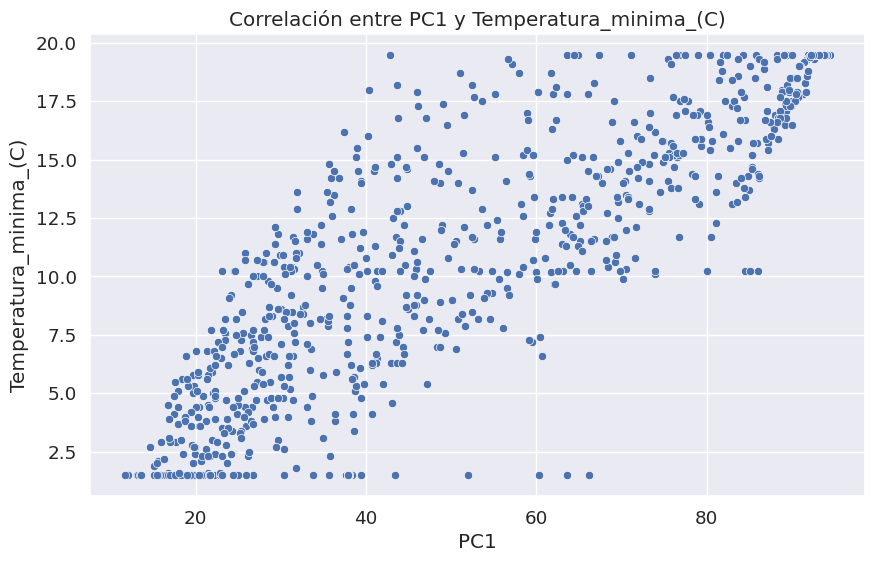

In [ ]:

# Configurar el tamaño de la fuente en los gráficos de seaborn
sns.set(font_scale=1.2)  # Ajusta el tamaño de la fuente según tus preferencias

# Crear un DataFrame combinando la PC1 y la variable seleccionada para PC1
df_pc1_vs_variable = pd.DataFrame({
    'PC1': numeric_data.dot(loadings_pc1),
    selected_variables_pc1['Variable'].iloc[0]: df[selected_variables_pc1['Variable'].iloc[0]]
})

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura según tus preferencias
sns.scatterplot(x='PC1', y=selected_variables_pc1['Variable'].iloc[0], data=df_pc1_vs_variable)

# Añadir etiquetas y título
plt.xlabel('PC1')
plt.ylabel(selected_variables_pc1['Variable'].iloc[0])
plt.title('Correlación entre PC1 y {}'.format(selected_variables_pc1['Variable'].iloc[0]))

# Mostrar el gráfico
plt.show()

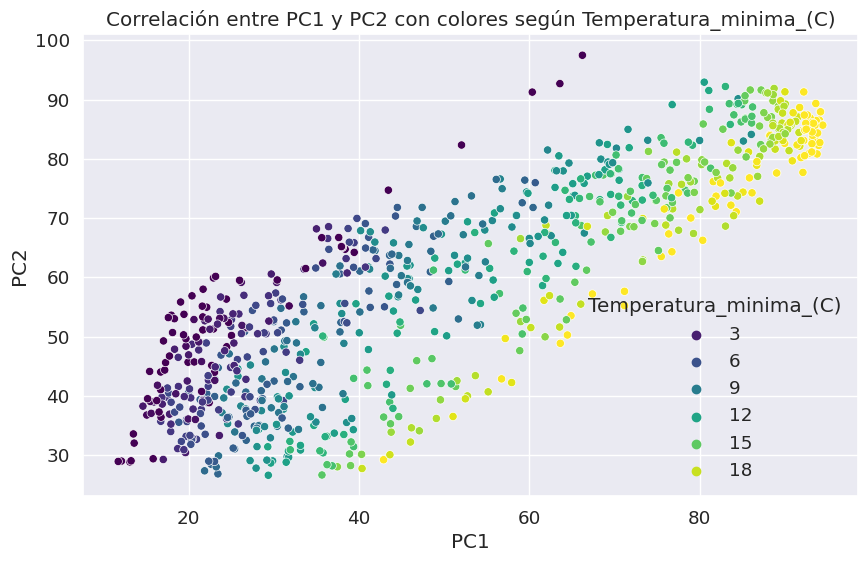

In [ ]:

# Crear un DataFrame combinando PC1, PC2 y la variable seleccionada para PC1
df_pc1_pc2_vs_variable = pd.DataFrame({
    'PC1': numeric_data.dot(loadings_pc1),
    'PC2': numeric_data.dot(loadings_pc2),
    selected_variables_pc1['Variable'].iloc[0]: df[selected_variables_pc1['Variable'].iloc[0]]
})

# Crear el gráfico de dispersión con colores según la variable original
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura según tus preferencias
sns.scatterplot(x='PC1', y='PC2', hue=selected_variables_pc1['Variable'].iloc[0], data=df_pc1_pc2_vs_variable, palette='viridis')

# Añadir etiquetas y título
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Correlación entre PC1 y PC2 con colores según {}'.format(selected_variables_pc1['Variable'].iloc[0]))

# Mostrar el gráfico
plt.show()

**KMEANS**

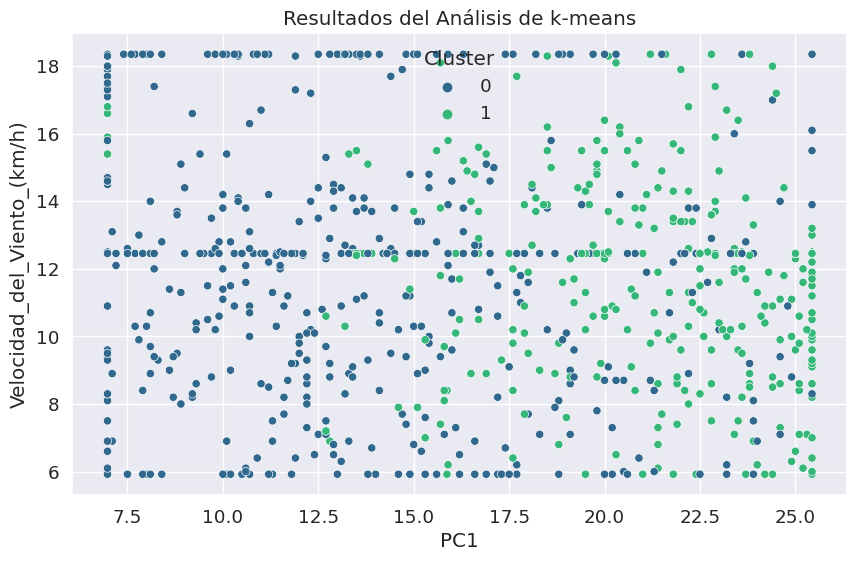

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame df con tus datos

# Selecciona las columnas relevantes para el análisis de k-means
data_for_kmeans = df1

# Especifica el número de clústeres (k) que deseas encontrar
k = 2

# Crea y ajusta el modelo k-means
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(data_for_kmeans)

# Visualiza los resultados
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperatura_(C)', y='Velocidad_del_Viento_(km/h)', hue='Cluster', data=df, palette='viridis', legend='full')
plt.title('Resultados del Análisis de k-means')
plt.xlabel('PC1')
plt.ylabel('Velocidad_del_Viento_(km/h)')
plt.show()


In [ ]:
# Supongamos que tienes un DataFrame df1 con tus datos

# Selecciona las columnas relevantes para el análisis de k-means
data_for_kmeans = df1[['Temperatura_(C)', 'Temperatura_maxima_(C)', 'Temperatura_minima_(C)', 'Humedad_relativa_(%)', 'Velocidad_del_Viento_(km/h)', 'Nubosidad_total_(octavos)', 'Precipitacion_(mm)', 'Frecuencia_dias_Precipitacion_>0.1_mm']]

# Especifica el número de clústeres (k) que deseas encontrar
k = 5

# Crea y ajusta el modelo k-means
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=150, max_iter=1000, random_state=42)
df1['Cluster'] = kmeans.fit_predict(data_for_kmeans)

# Resultados del análisis de k-means
cluster_centers = kmeans.cluster_centers_
within_cluster_ss = np.zeros((k, 1))

for i in range(k):
    cluster_data = data_for_kmeans[df1['Cluster'] == i]
    within_cluster_ss[i, 0] = np.sum((cluster_data.values - cluster_centers[i:i+1, :]) ** 2)

total_within_cluster_ss = within_cluster_ss.sum()
total_sum_of_squares = np.sum((data_for_kmeans.values - np.mean(data_for_kmeans.values)) ** 2)
between_cluster_ss = total_sum_of_squares - total_within_cluster_ss
ratio_between_to_total_ss = between_cluster_ss / total_sum_of_squares

# Mostrar resultados
print("Cluster centers:")
print(pd.DataFrame(cluster_centers, columns=data_for_kmeans.columns))
print("\nWithin-cluster sum of squares:")
print(pd.DataFrame(within_cluster_ss, columns=['Within cluster S.S.']))
print("\nThe total within-cluster sum of squares:", total_within_cluster_ss)
print("The between-cluster sum of squares:", between_cluster_ss)
print("The ratio of between to total sum of squares:", ratio_between_to_total_ss)


Cluster centers:
   Temperatura_(C)  Temperatura_maxima_(C)  Temperatura_minima_(C)  \
0        13.948870               21.472931                7.595643   
1        22.418245               28.745095               16.880747   
2        14.289113               20.674951                8.896502   
3        12.067096               18.736201                6.560782   
4        19.756175               26.169961               13.906867   

   Humedad_relativa_(%)  Velocidad_del_Viento_(km/h)  \
0             60.388400                    11.574583   
1             72.608247                    10.758686   
2             70.903630                    12.918928   
3             71.153066                    12.340913   
4             71.252799                    12.330181   

   Nubosidad_total_(octavos)  Precipitacion_(mm)  \
0                   3.526685           13.757360   
1                   3.674827          133.324243   
2                   3.988511           65.852942   
3                

# Cluster Jerárquico


Number of clusters: 7
Transformation: Standardize (Z)
Method: Single-linkage
Distance function: Euclidean

Cluster centers:
  Temperatura_(C) Temperatura_maxima_(C) Temperatura_minima_(C)  \
1          12.725                   20.3                    6.9   
2       15.871838              30.696865              19.476744   
3       16.302393              22.977657              10.533092   
4            12.8                   21.7                    5.2   
5            20.5                   27.5                   14.1   
6            20.2                   25.5                   17.0   
7            19.1                   26.8                   11.8   

  Humedad_relativa_(%) Velocidad_del_Viento_(km/h) Nubosidad_total_(octavos)  \
1                62.75                         7.2                  4.459197   
2            68.044581                    7.159891                  3.817191   
3            68.914498                   12.030743                  3.744279   
4             54.58

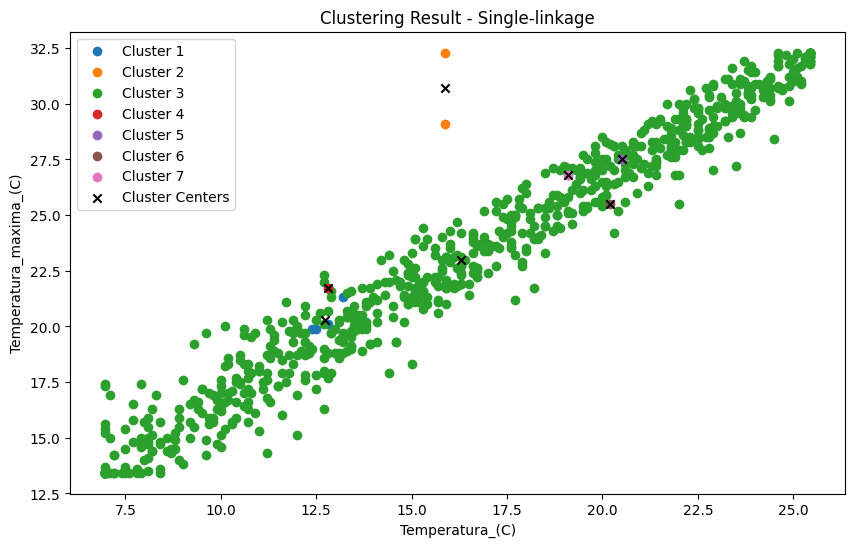


------

Number of clusters: 7
Transformation: Standardize (Z)
Method: Complete-linkage
Distance function: Euclidean

Cluster centers:
  Temperatura_(C) Temperatura_maxima_(C) Temperatura_minima_(C)  \
1       23.275053              30.534882              16.526131   
2       10.318204              17.970909               4.462395   
3       16.118261              23.612174               9.459794   
4       21.033381              27.463896               15.29356   
5        7.398334              13.747007               1.967754   
6       13.046669              19.337773               7.155172   
7       11.780352              17.840876               7.080833   

  Humedad_relativa_(%) Velocidad_del_Viento_(km/h) Nubosidad_total_(octavos)  \
1            57.159639                    12.85872                   3.30286   
2            65.215676                     9.60786                  3.583573   
3            60.981116                    11.60362                  3.289727   
4       

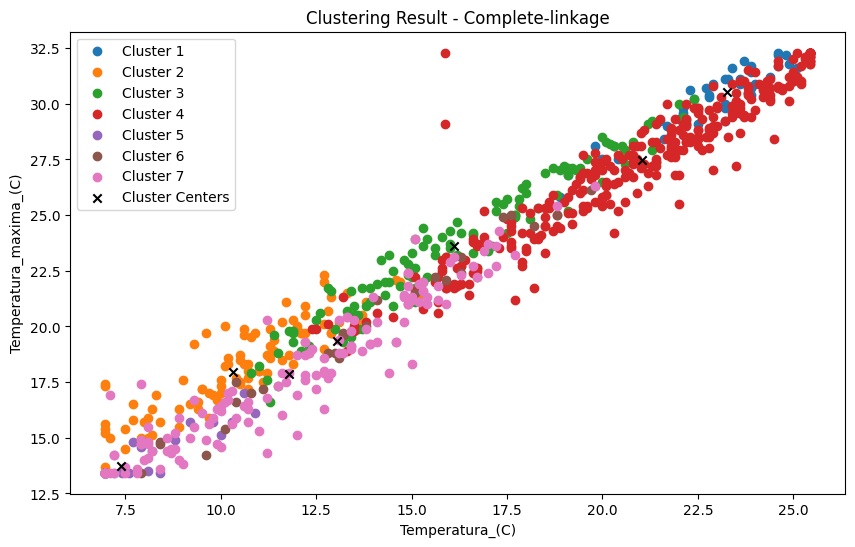


------

Number of clusters: 7
Transformation: Standardize (Z)
Method: Average-linkage
Distance function: Euclidean

Cluster centers:
  Temperatura_(C) Temperatura_maxima_(C) Temperatura_minima_(C)  \
1          12.725                   20.3                    6.9   
2        8.450139              14.757732               2.928323   
3       11.838542              18.715656               6.393999   
4            18.6              25.509091              11.827273   
5       20.444585              28.114677              13.190557   
6       21.191785               27.65765              15.434164   
7       21.535162              27.820352              15.753528   

  Humedad_relativa_(%) Velocidad_del_Viento_(km/h) Nubosidad_total_(octavos)  \
1                62.75                         7.2                  4.459197   
2            67.026301                   18.057692                  4.436045   
3            70.331261                    10.94164                  3.778903   
4        

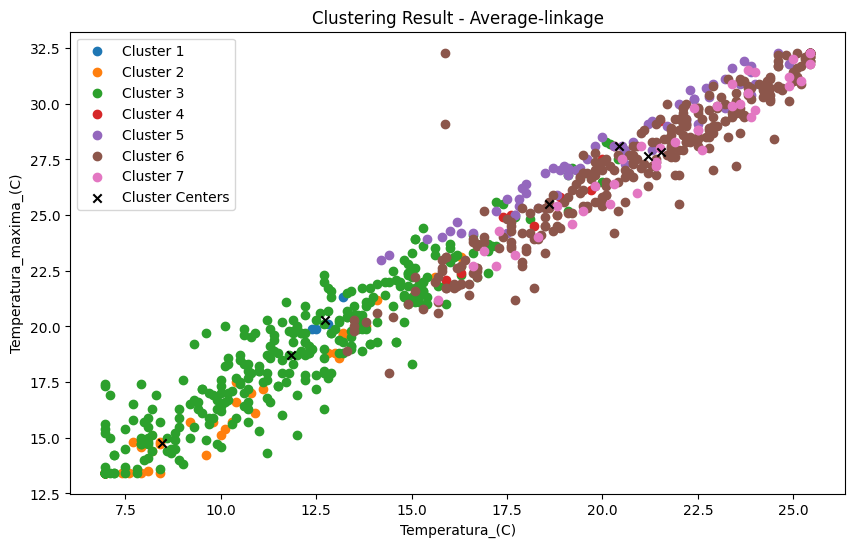


------



In [39]:
# Seleccionar las variables relevantes para el clustering
variables_clustering = df1[['Temperatura_(C)', 'Temperatura_maxima_(C)', 'Temperatura_minima_(C)',
                            'Humedad_relativa_(%)', 'Velocidad_del_Viento_(km/h)',
                            'Nubosidad_total_(octavos)', 'Precipitacion_(mm)',
                            'Frecuencia_dias_Precipitacion_>0.1_mm']]

# Normalizar los datos (si es necesario)
normalized_data = (variables_clustering - variables_clustering.mean()) / variables_clustering.std()

# Realizar clustering jerárquico
Z_single = linkage(normalized_data, method='single', metric='euclidean')
Z_complete = linkage(normalized_data, method='complete', metric='euclidean')
Z_average = linkage(normalized_data, method='average', metric='euclidean')

# Obtener asignaciones de clusters
num_clusters = 7
clusters_single = fcluster(Z_single, num_clusters, criterion='maxclust')
clusters_complete = fcluster(Z_complete, num_clusters, criterion='maxclust')
clusters_average = fcluster(Z_average, num_clusters, criterion='maxclust')

# Mostrar resultados
for method, clusters in [('Single', clusters_single), ('Complete', clusters_complete), ('Average', clusters_average)]:
    print(f"Number of clusters: {num_clusters}")
    print(f"Transformation: Standardize (Z)")
    print(f"Method: {method}-linkage")
    print(f"Distance function: Euclidean\n")

    # Mostrar los centros de los clusters
    cluster_centers = pd.DataFrame(index=range(1, num_clusters + 1), columns=variables_clustering.columns)
    for i in range(1, num_clusters + 1):
        cluster_data = variables_clustering[clusters == i].mean()
        cluster_centers.loc[i, :] = cluster_data.values if len(cluster_data) == len(variables_clustering.columns) else [np.nan] * len(variables_clustering.columns)

    print("Cluster centers:")
    print(cluster_centers)

    # Visualizar los clusters
    plt.figure(figsize=(10, 6))
    for cluster_num in range(1, num_clusters + 1):
        cluster_points = variables_clustering[clusters == cluster_num]
        plt.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1], label=f'Cluster {cluster_num}')

    plt.scatter(cluster_centers.iloc[:, 0], cluster_centers.iloc[:, 1], color='black', marker='x', label='Cluster Centers')
    plt.title(f'Clustering Result - {method}-linkage')
    plt.xlabel(variables_clustering.columns[0])
    plt.ylabel(variables_clustering.columns[1])
    plt.legend()
    plt.show()

    print("\n------\n")


[link text](https://)